## Description
Quantum state tomography on single qubit mixed states, and compared to state tomography with uniformly sampled pauli measurements

In [1]:
%load_ext autoreload
%autoreload 2
#import adaptive_qst.max_info as max_info
from qiskit.quantum_info import random_density_matrix, random_statevector, DensityMatrix
from adaptive_qst.plotting import PlotOneQubit
from adaptive_qst.max_info import Posterior, HiddenState
import matplotlib.pyplot as plt
from numpy import pi
from qiskit.quantum_info import state_fidelity

import numpy as np
from numpy import sqrt
from numpy.linalg import cholesky

## Comparison with pauli basis measurements

Takeaways:
- It is sometimes better?

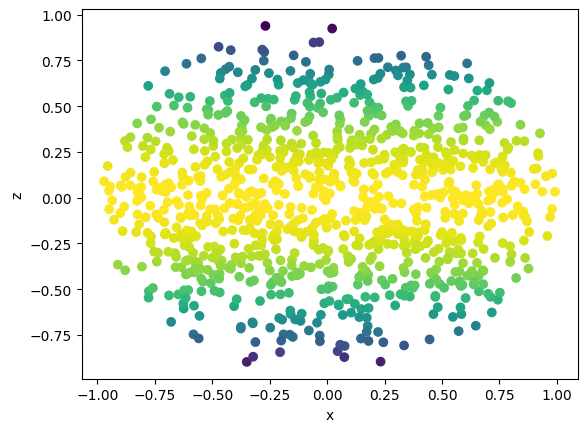

In [55]:
posterior = Posterior(1000)
fig, ax = plt.subplots()

posterior.update([0, 0], 0)
posterior.update([0, 0], 1)

# posterior.update([pi/2, 0], 0)
# posterior.update([pi/2, 0], 1)

# posterior.update([pi/2, pi/2], 0)
# posterior.update([pi/2, pi/2], 1)

posterior.resample()

PlotOneQubit.plot_posterior(posterior, 'xz', ax)

In [66]:
n_measurements = 10_000
pure_state = random_statevector(2)
hidden_state = HiddenState(DensityMatrix(pure_state).data)
hidden_state.hidden_state

array([[ 0.06586248+0.j        , -0.01463764-0.24760928j],
       [-0.01463764+0.24760928j,  0.93413752+0.j        ]])

In [67]:
infidelity_arr_mub = []
pauli_configs = [[pi/2, 0], [pi/2, pi/2], [0, 0]]

tots = np.zeros(3)
counts = np.zeros(3)
probs = 0.5 * np.ones(3)

for i in range(n_measurements):
    basis = i % 3
    result = hidden_state.measure_along_axis(pauli_configs[basis])
    
    tots[basis] += (result == 0)
    counts[basis] += 1
    
    probs[basis] = tots[basis] / counts[basis]
        
    comps = 2 * probs - 1
    
    if np.sum(comps ** 2) > 1:
        comps /= np.sum(comps ** 2)
        
    best_guess = 0.5 * np.array([[1 + comps[2], comps[0] - comps[1] * 1j],
                           [comps[0] + comps[1] * 1j, 1 - comps[2]]])
    
    infidelity_arr_mub.append(1 - state_fidelity(hidden_state.hidden_state, best_guess))

In [68]:
n_particles = 100
infidelity_arr_bayes = []
posterior = Posterior(n_particles)

for i in range(n_measurements):
    if i % 500 == 0:
        print(f"Step {i}")
        
    config = posterior.get_best_config()
    res = hidden_state.measure_along_axis(config)
    posterior.update(config, res)
    
    infidelity_arr_bayes.append(1 - state_fidelity(posterior.get_best_guess(), hidden_state.hidden_state))

Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Step 3000
Step 3500
Step 4000
Step 4500
Step 5000
Step 5500
Step 6000
Step 6500
Step 7000
Step 7500
Step 8000
Step 8500
Step 9000
Step 9500


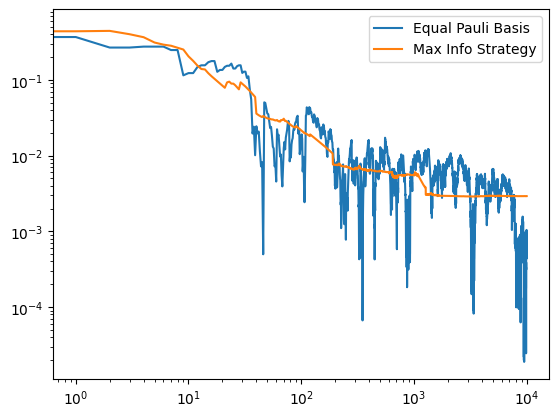

In [70]:
fig, ax = plt.subplots()

ax.plot(np.arange(n_measurements), infidelity_arr_mub, label = "Equal Pauli Basis")
ax.plot(np.arange(n_measurements), infidelity_arr_bayes, label = "Max Info Strategy")

ax.set_yscale('log')
ax.set_xscale('log')
plt.legend()

## Comparison with mub and random
- In Bayesian framework, average over 50 samples for mixed states, then 50 samples for pure states. 
- With 30 particles, try max info, random axis, and pauli basis, where figure of merit is the weighted average fidelity of the posterior
- Main takeaway: Max info beats random axis/mub modestly for random mixed states (2x as good after 5000 steps), while beating random axis/mub significantly for random pure states

In [100]:
pauli_configs = [[pi/2, 0], [pi/2, pi/2], [0, 0]]

INFO = 0
RANDOM = 1
PAULI = 2

def run_bayes(hidden_state, n_measurements, n_particles, model, data_freq):
    infidelity_arr = np.zeros(n_measurements // data_freq)
    posterior = Posterior(n_particles)

    for i in range(n_measurements):
        
        if model == INFO:
            config = posterior.get_best_config()
            
        elif model == RANDOM:
            config = pi * np.random.rand(2)
            
        elif model == PAULI:
            config = pauli_configs[i % 3]
            
        else:
            print("Unknown model!!")
            
        res = hidden_state.measure_along_axis(config)
        posterior.update(config, res)
        
        if i % data_freq == 0:
            #print(f"Collecting data: {i}")
            fids = map(lambda x: state_fidelity(hidden_state.hidden_state, x), posterior.particle_states)
            infidelity_arr[i // data_freq] = 1 - np.sum(np.array(list(fids)) * posterior.particle_weights)
        
        
    return infidelity_arr

In [ ]:
n_tests = 50
n_measurements = 5000
n_models = 3
data_freq = 100 ## How often to collect data
pure_state = False

infidelities = np.zeros((n_tests, n_models, n_measurements // data_freq))

import time
start = time.time()

for i in range(n_tests):
    print(f"Running test {i}")
    
    for j in range(n_models):
        print(f"Running subtest {j}")
        
        if pure_state:
            hidden_state = HiddenState(DensityMatrix(random_statevector(2)).data)
        
        else:
            hidden_state = HiddenState(random_density_matrix(2).data)
        
        infidelities[i, j] = run_bayes(hidden_state, n_measurements, n_particles = 30, model = j, data_freq = data_freq)
    
print(time.time() - start)

In [105]:
np.savez("data/avg_fidelity_mixed", arr_1 = infidelities)

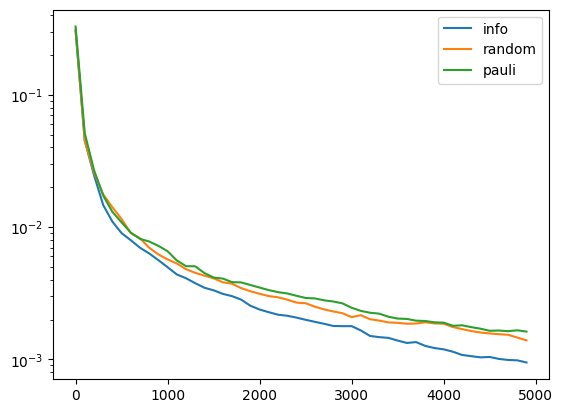

In [111]:
infidelities = np.load("data/avg_fidelity_mixed.npz")['arr_1']
avgs = np.mean(infidelities, axis = 0)

plt.plot(np.arange(0, n_measurements, data_freq), avgs[0], label = "info")
plt.plot(np.arange(0, n_measurements, data_freq), avgs[1], label = "random")
plt.plot(np.arange(0, n_measurements, data_freq), avgs[2], label = "pauli")

plt.yscale('log')
plt.legend()

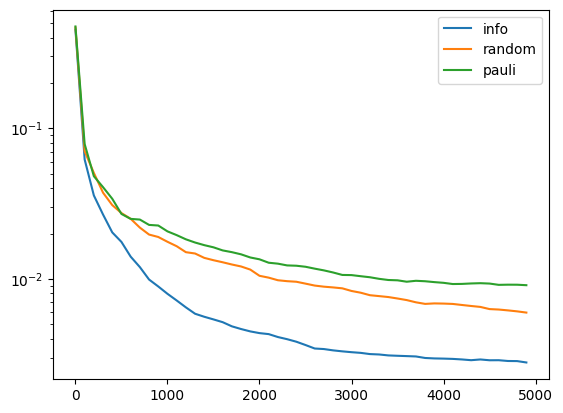

In [112]:
infidelities = np.load("data/avg_fidelity_pure.npz")['arr_1']
avgs = np.mean(infidelities, axis = 0)

plt.plot(np.arange(0, n_measurements, data_freq), avgs[0], label = "info")
plt.plot(np.arange(0, n_measurements, data_freq), avgs[1], label = "random")
plt.plot(np.arange(0, n_measurements, data_freq), avgs[2], label = "pauli")

plt.yscale('log')
plt.legend()